In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.integrate as integrate
from tqdm.auto import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
plt.style.use("default")
plt.rcParams.update(
    {
        "figure.constrained_layout.use": True,
        "figure.facecolor": "white",
    }
)

n_dense_points = 201


In [2]:
def Separable(t, y):
    """Exact equation y' = (3*t**2+4*t+2)/(2y-2)
    """
    return (3*t**2+4*t+2)/(2*y-2)

def Separable_exact(t, y0):
    return 1.0-np.sqrt(t**3+2.0*t**2+2.0*t+(y0-1)**2)

In [3]:
domain = (0, 1)
t0 = 0.0
y0 = -1.0

t_dense = np.linspace(*domain, n_dense_points)

In [4]:
class MLP(nn.Module):
    def __init__(self, *features, activation=nn.Tanh):
        super().__init__()

        layers = []
        for in_features, out_features in zip(features, features[1:]):
            layers.append(nn.Linear(in_features, out_features))
            layers.append(activation())
        self.network = nn.Sequential(*layers[:-1])

    def forward(self, x):
        return self.network(x)

In [5]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

In [6]:
torch.manual_seed(78)
model = MLP(1, 16, 32, 1)
t0=0.0
y0=-1.0

In [7]:
batch_size = 10000
n_epochs = 1_000
print_interval = n_epochs // 10
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.98 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

loss_history = []
realloss_history=[]
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # 무작위 t 생성 후 y 계산
    t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
    y = model(t)
    y_e=1.0-torch.sqrt(t**3+2.0*t**2+2.0*t+4)
    y_t = grad(y, t)

    # Loss
    loss_de = F.mse_loss( (3*t**2+4*t+2)/(2*y-2)- y_t, torch.zeros_like(y_t))
    loss_bc = F.mse_loss(model(torch.tensor([[t0]])), torch.tensor([[y0]]))
    loss = loss_de + loss_bc
    realloss=F.mse_loss(y-y_e, torch.zeros_like(y))**0.5
    # Backprop
    loss.backward()
    loss = loss_de**0.5+loss_bc**0.5
    optimizer.step()

    loss_history.append(loss.item())
    realloss_history.append(realloss.item())
    if epoch % print_interval == 0:
        print(f"{epoch = }, loss_de = {loss_de.item():.4f}, loss_bc = {loss_bc.item():.4f}, loss = {loss.item():.4f}")


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch = 0, loss_de = 18.3423, loss_bc = 1.3926, loss = 5.4629
epoch = 100, loss_de = 0.1073, loss_bc = 0.0004, loss = 0.3482
epoch = 200, loss_de = 0.0022, loss_bc = 0.0000, loss = 0.0470
epoch = 300, loss_de = 0.0019, loss_bc = 0.0000, loss = 0.0433
epoch = 400, loss_de = 0.0015, loss_bc = 0.0000, loss = 0.0387
epoch = 500, loss_de = 0.0012, loss_bc = 0.0000, loss = 0.0344
epoch = 600, loss_de = 0.0009, loss_bc = 0.0000, loss = 0.0301
epoch = 700, loss_de = 0.0007, loss_bc = 0.0000, loss = 0.0273
epoch = 800, loss_de = 0.0006, loss_bc = 0.0000, loss = 0.0239
epoch = 900, loss_de = 0.0004, loss_bc = 0.0000, loss = 0.0193


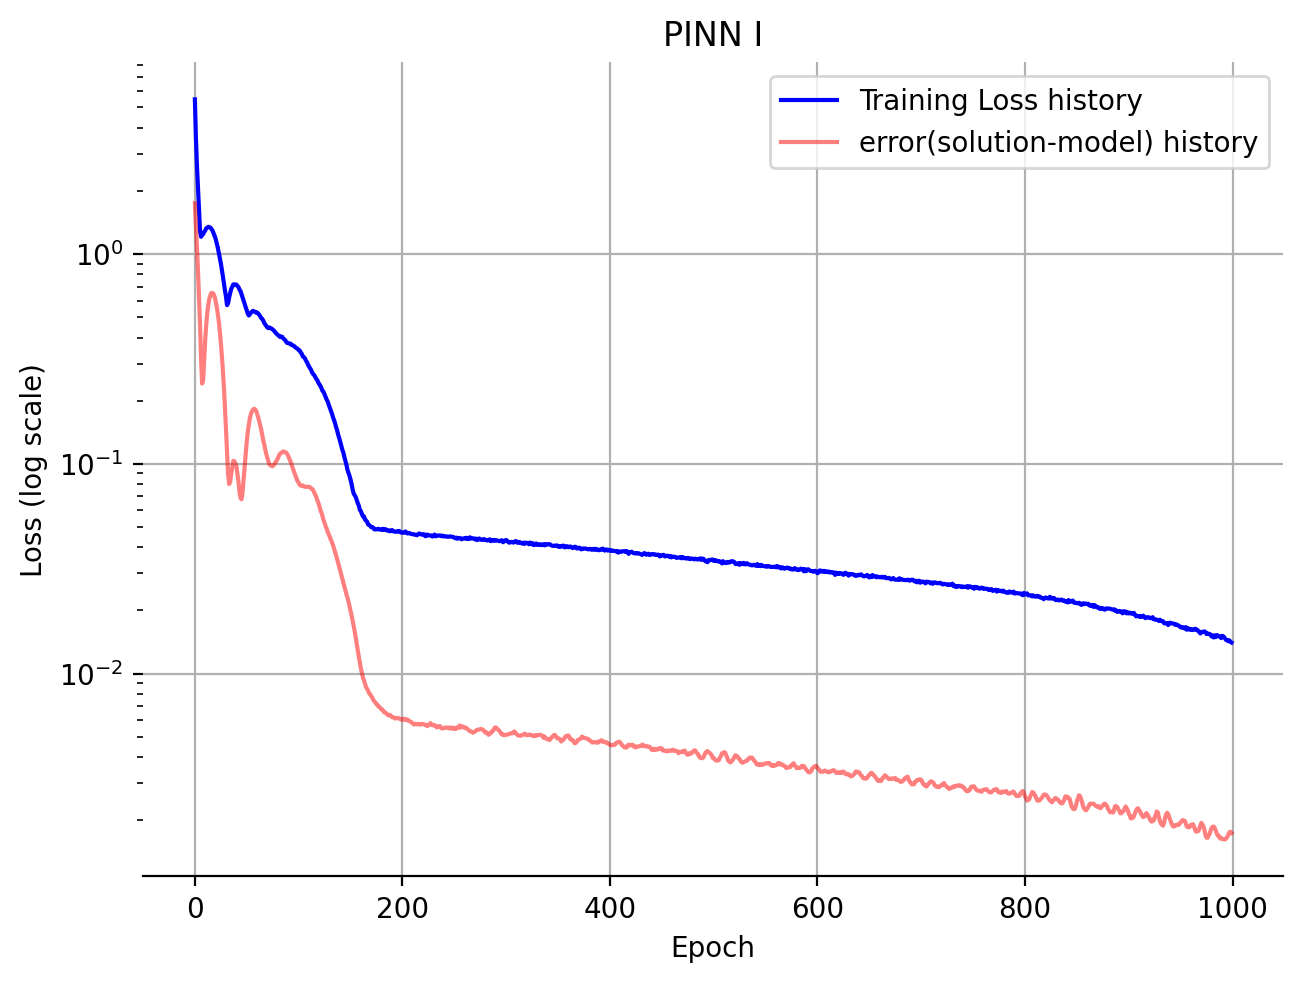

In [8]:
fig, ax = plt.subplots()
ax.plot(loss_history,"b", label = "Training Loss history")
ax.plot(realloss_history,"r",alpha=0.5, label = "error(solution-model) history")
ax.set(
    yscale="log",
    xlabel="Epoch",
    ylabel="Loss (log scale)",
    title = "PINN I"
)
ax.legend()
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass


In [9]:
X=np.array(loss_history)
Y=np.array(realloss_history)

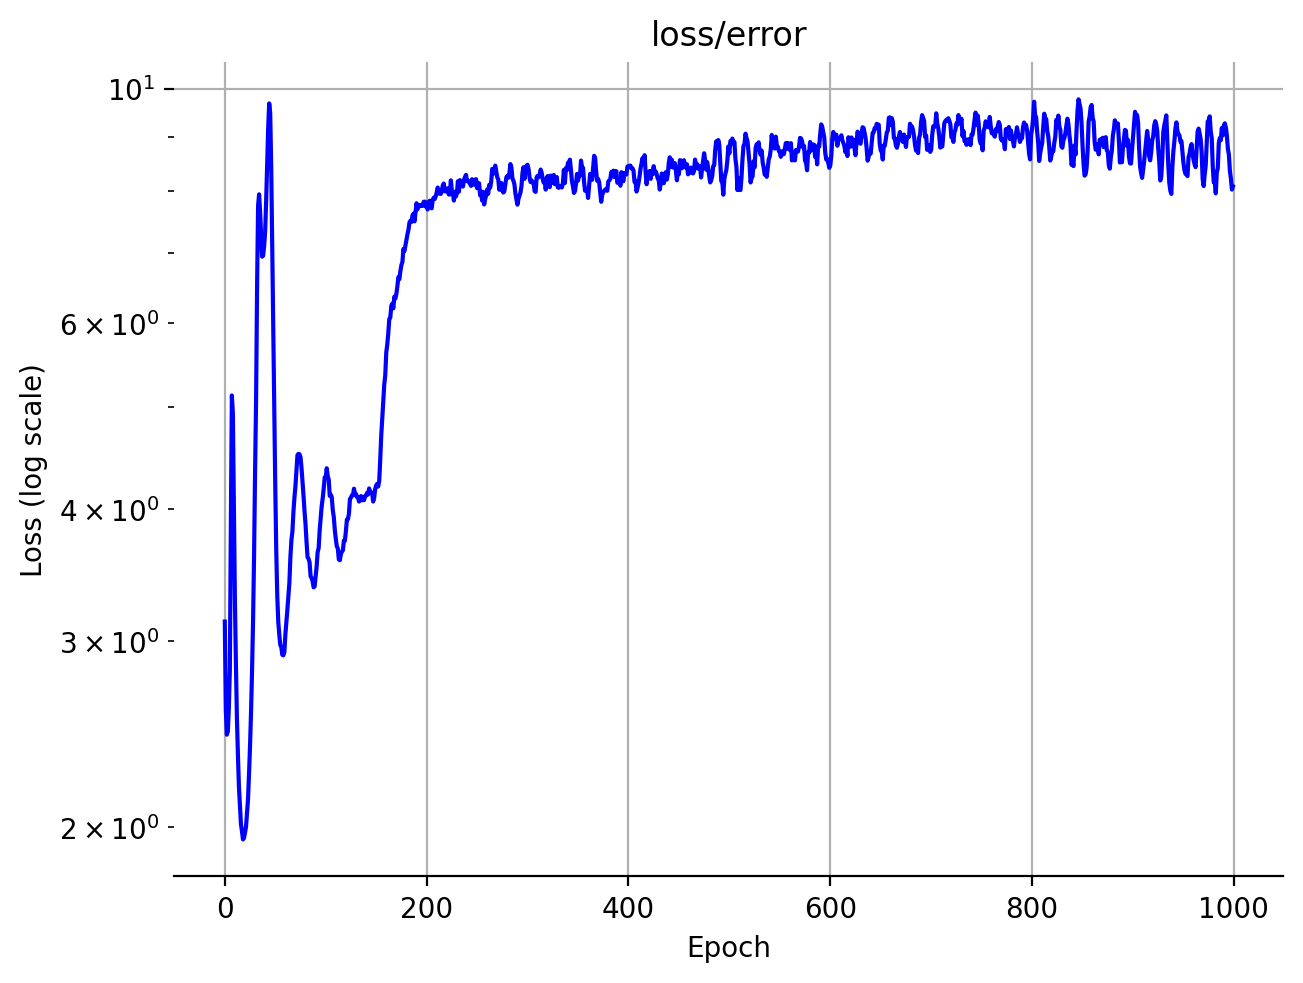

In [10]:
fig, ax = plt.subplots()
ax.plot(X/Y,"b")
# plt.axhline(1.0, 0, 1, color='C0', linestyle='--', linewidth=2)
ax.set(
    yscale="log",    ylabel="Loss (log scale)",    xlabel="Epoch",
    title="loss/error"
)
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass

In [11]:
torch.manual_seed(78)
model = MLP(1, 16, 32, 1)

In [12]:
batch_size = 10000
n_epochs = 1_000
print_interval = n_epochs // 10
learning_rate = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.98 ** epoch,
                                        last_epoch=-1,
                                        verbose=False)

loss_history = []
realloss_history=[]
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # 무작위 t 생성 후 y 계산
    t = torch.empty(batch_size, 1).uniform_(*domain).requires_grad_()
    y = t*model(t)-1
    y_e= 1.0-torch.sqrt(t**3+2.0*t**2+2.0*t+4)
    y_t = grad(y, t)

    # Loss
    loss_de = F.mse_loss((3*t**2+4*t+2)/(2*y-2) - y_t, torch.zeros_like(y_t))
    loss = loss_de
    realloss=F.mse_loss(y-y_e, torch.zeros_like(y))**0.5
    # Backprop
    loss.backward()
    loss=loss_de**0.5
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.item())
    realloss_history.append(realloss.item())
    if epoch % print_interval == 0:
        print(f"{epoch = }, loss_de = {loss_de.item():.4f}, loss_bc = {loss_bc.item():.4f}, loss = {loss.item():.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch = 0, loss_de = 3.8223, loss_bc = 0.0000, loss = 1.9551
epoch = 100, loss_de = 0.0021, loss_bc = 0.0000, loss = 0.0459
epoch = 200, loss_de = 0.0019, loss_bc = 0.0000, loss = 0.0432
epoch = 300, loss_de = 0.0019, loss_bc = 0.0000, loss = 0.0433
epoch = 400, loss_de = 0.0018, loss_bc = 0.0000, loss = 0.0426
epoch = 500, loss_de = 0.0018, loss_bc = 0.0000, loss = 0.0426
epoch = 600, loss_de = 0.0018, loss_bc = 0.0000, loss = 0.0422
epoch = 700, loss_de = 0.0018, loss_bc = 0.0000, loss = 0.0426
epoch = 800, loss_de = 0.0018, loss_bc = 0.0000, loss = 0.0427
epoch = 900, loss_de = 0.0018, loss_bc = 0.0000, loss = 0.0427


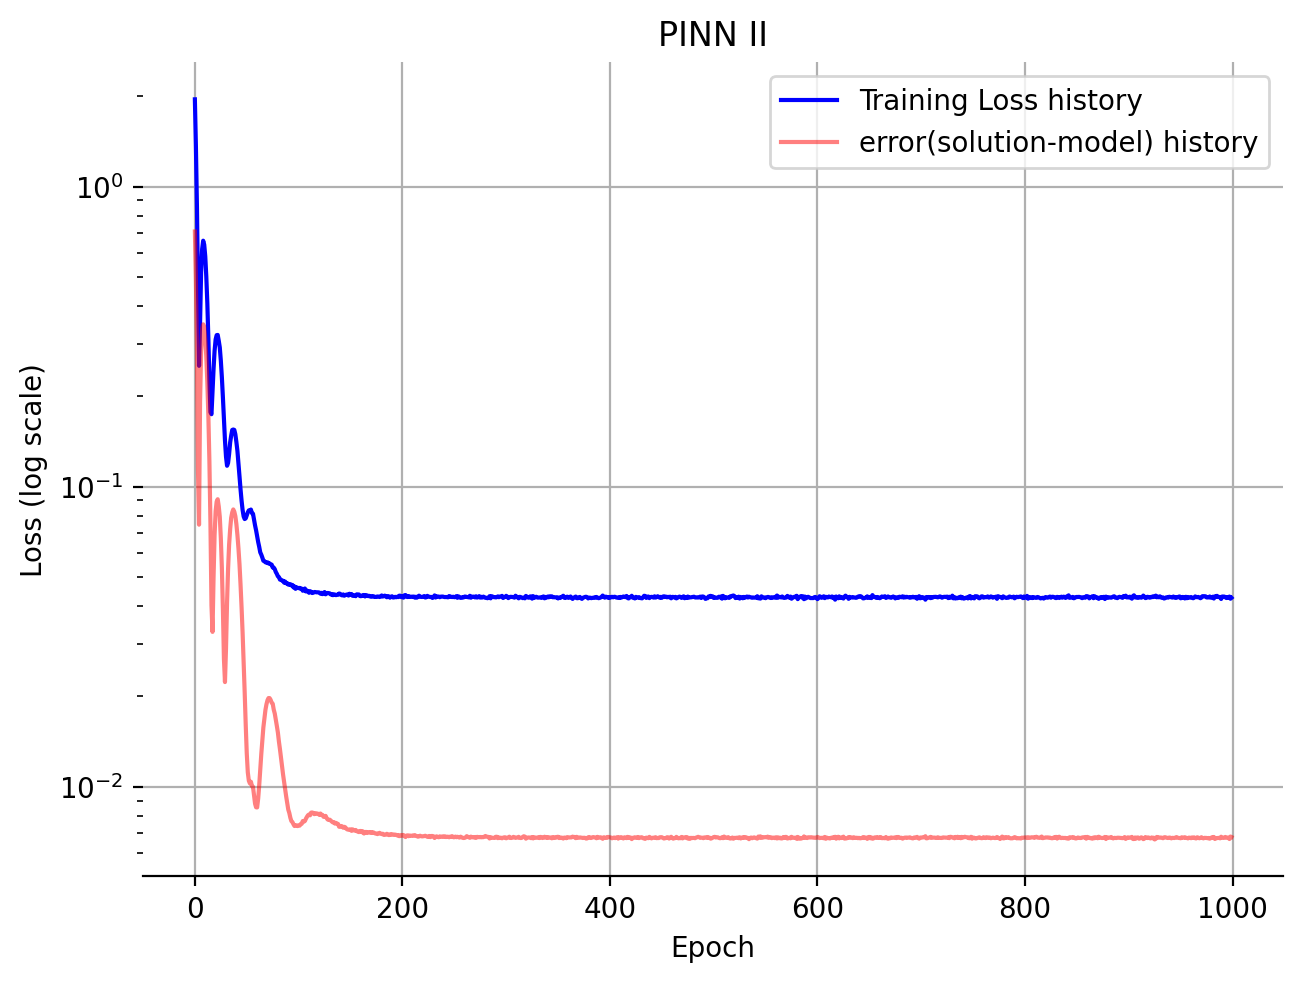

In [13]:
fig, ax = plt.subplots()
ax.plot(loss_history,"b", label = "Training Loss history")
ax.plot(realloss_history,"r",alpha=0.5, label = "error(solution-model) history")
ax.set(
    yscale="log",
    xlabel="Epoch",
    ylabel="Loss (log scale)",
    title = "PINN II"
)
ax.legend()
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass


In [14]:
X=np.array(loss_history)
Y=np.array(realloss_history)

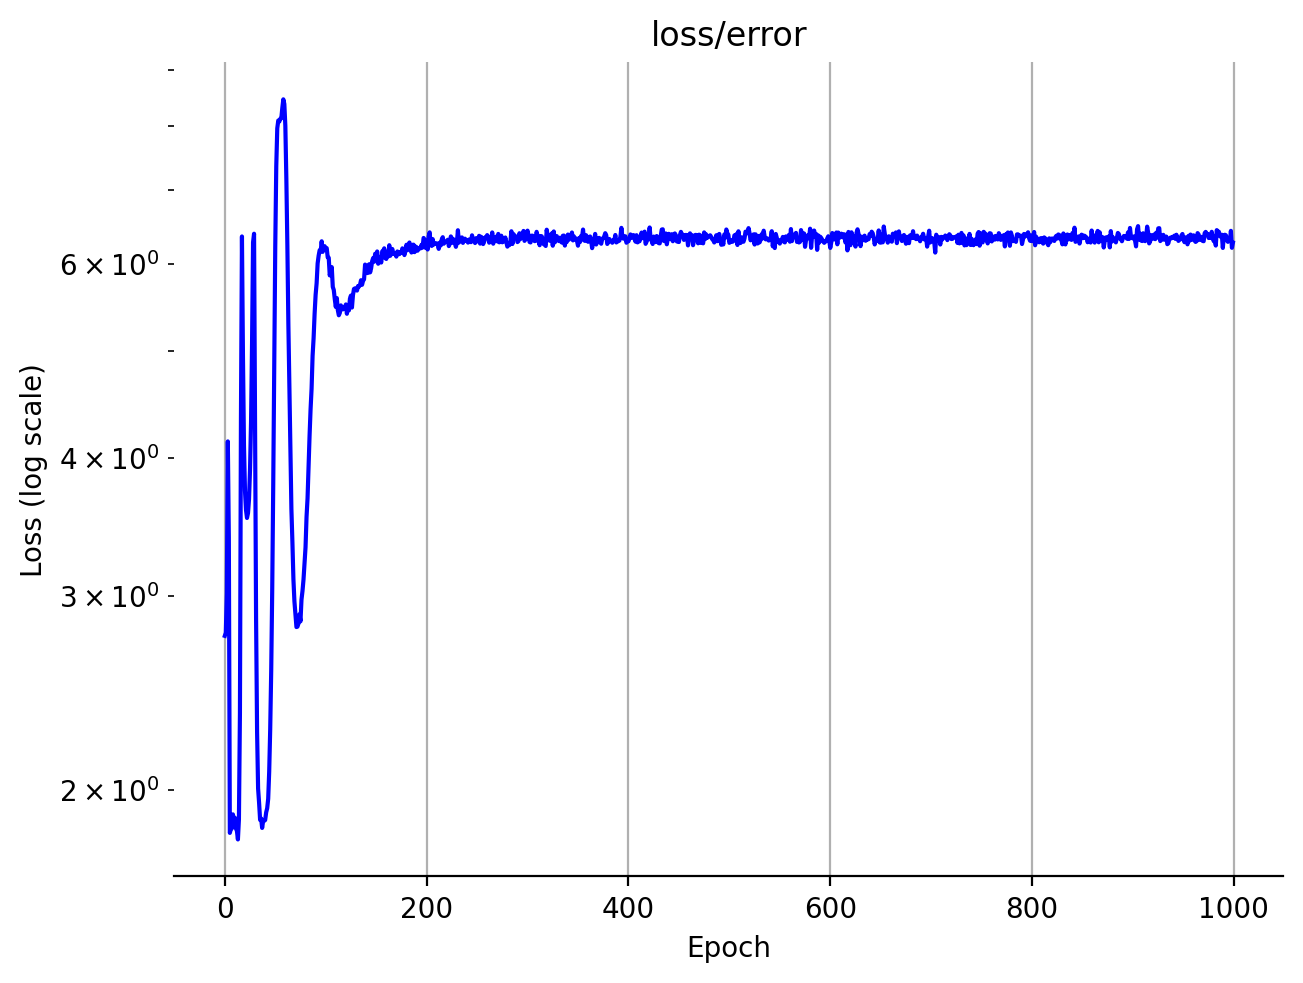

In [15]:
fig, ax = plt.subplots()
ax.plot(X/Y,"b")
# plt.axhline(1.0, 0, 1, color='C0', linestyle='--', linewidth=2)
ax.set(
    yscale="log",    ylabel="Loss (log scale)",    xlabel="Epoch",
    title="loss/error"
)
ax.grid()
ax.spines[["top", "right", "left"]].set_visible(False)
pass